## **Контрольная работа по Методам оптимизаций**

#### Гапонов Максим, Б05-921

# **Convex Analysis of Mixture Non-negative Sources (CAMNS)**

Задача **CAMNS** ставится следующим образом.

Пусть имеется несколько объектов $s_1, s_2, \dots, s_n$. Рассмотрим смеси этих объектов, такие, что сумма неотрицательных коэффициентов в них равна $1$. $x_i=\sum\limits_{i=1}^n {a_{ij}s_j}$. Задача состоит в том, чтобы по смесям найти исходные объекты.

Для простоты мы будем рассматривать случай, когда количество смесей равно количеству объектов.

Будем работать с изображениями. Изображение $~-$ это тензор размера $(W, H, C)$, где $W,H ~-$ ширина и высота изображния, $C ~-$ количество цветовых каналов.

Ссылку на оригинальную статью можно найти [тут](https://www.researchgate.net/profile/Chong-Yung-Chi/publication/251134144_A_Convex_Analysis_Framework_for_Blind_Separation_of_NonNegative_Sources/links/5a1e7622aca272cbfbc04995/A-Convex-Analysis-Framework-for-Blind-Separation-of-NonNegative-Sources.pdf?_sg%5B0%5D=OMb8GSQ1miraTnwj9MuTl_sWqMTmx1MXLO3B6zfVi4OFqD1thTV7qA1ojzXKQSucagGKOYVy8QmNQOoE5oLX7Q.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_sg%5B1%5D=WIdyA5iABGfzLmDfwEfigkwWoN-Ahwrw8Z3t4D_7wZLt5iAIKaiCWZQYsLGAFMr59D7yASkWgn4KQy0-4-DErwnDWhtnvybd10KIsKCKc3BT.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_iepl=).

Для начала научимся работать с изображениями.

In [ ]:
import scipy as sp
import numpy as np
import cvxpy as cp
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def get_image(filename, root_dir='./images/'):
    return np.array(Image.open(root_dir + filename)).astype('float64') / 255

def get_images(filenames, root_dir='./images/'):
    return [get_image(filename, root_dir) for filename in filenames]

def show_image(image):
    if len(image.shape) == 2: # grey scale
        image = np.repeat(image, 3).reshape((np.append(image.shape, 3)))
    plt.imshow(image)
    plt.axis('off')

def show_images(images, figsize=None, title=None):
    rows = len(images)
    cols = len(images[0])
    plt.figure(figsize=figsize)
    idx = 0
    for image_row in images:
        for image in image_row:
            idx += 1
            plt.subplot(rows, cols, idx)
            show_image(image)
    plt.title(title)
    plt.show()

In [ ]:
img_files = ['cao1.jpg', 'ksiwek1.jpg', 'zhang1.jpg']

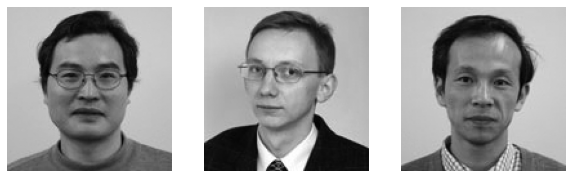

In [ ]:
imgs = get_images(img_files)
show_images([imgs], figsize=(10, 4))

Теперь научимся смешивать изображения.

In [ ]:
def mix(elements, coefs):
    elements = np.array(elements)
    coefs = np.array(coefs)
    assert len(elements) == len(coefs), "Invalid number of coefficients"
    assert np.isclose(np.sum(coefs), 1), "Sum of coefficients should be 1"
    assert ((0 <= coefs) & (coefs <= 1)).all(), "Each coefficient should be in range [0; 1]"
    return (elements.T * coefs).sum(axis=-1).T

def random_mix(elements):
    n = len(elements)
    coefs = np.random.random(n)
    coefs /= np.sum(coefs)
    return mix(elements, coefs)

def random_mixes(elements, count):
    return [random_mix(elements) for _ in range(count)]

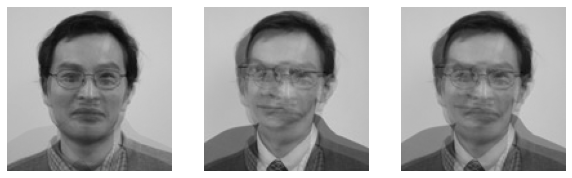

In [ ]:
images = get_images(img_files)
mixes = random_mixes(images, count=len(images))
show_images([mixes], figsize=(10, 4))

Реализуем алгоритм нахождения исходных изображений.

Основная идея алгоритма заключается в следующем. Исходные изображения и смеси лежат в одном аффинном пространстве. Его можно построить по смесям. Осталось найти в этом аффинном пространстве экстремальные точки, то есть точки на границе выпуклого множества, образованного исходными изображениями. Это можно сделать, решив задачу линейного программирования со случайным вектором весов. Тогда с большой вероятностью мы попадём в вершину, а не на грань. Повторим процедуру несколько раз, пока не найдём все вершины.

Объяснение лучше посмотреть в статье и презентации. Там объяснено более подробно и есть картинки.

In [ ]:
def add_ext_point(hS, C, alpha, d, tol=1e-3):
    p = C @ alpha + d
    T = C[abs(p) < tol, :]
    sin_value = np.linalg.svd(T, compute_uv=False)
    ran = np.sum((sin_value / np.sum(sin_value)) > tol)
    if ran < C.shape[1]:
      return hS
    else:
      return np.hstack([hS, p.reshape((-1, 1))])

def get_sources(mixtures, tol_lp=1e-3):
    N = len(mixtures)
    X = np.array(mixtures).astype('float64')
    Xshape = X.shape
    Lshape = Xshape[1:]
    X = X.reshape(N, -1).T
    L = X.shape[0]
    d = X[:, -1]
    C = (X[:, :-1].T - d).T
    B = np.eye(L)
    hS = np.zeros((L, 0))
    el = 0
    while el < N:
        w = np.random.standard_normal(L)
        r = B @ w
        alphas = []
        for sign in [1, -1]:
            alpha = cp.Variable((N - 1))
            obj = cp.Minimize(sign * r @ C @ alpha)
            prob = cp.Problem(obj, [C @ alpha + d >= 0])
            prob.solve()
            alphas.append(alpha.value)
        ps = [C @ alpha + d for alpha in alphas]
        if el == 0:
            for i in range(2):
                hS = add_ext_point(hS, C, alphas[i], d)
        else:
            pstars = [np.abs(r.dot(p)) for p in ps]
            for i in range(2):
                if pstars[i] >= tol_lp:
                    hS = add_ext_point(hS, C, alphas[i], d)
        el = hS.shape[1]
        if el > 0:
            Q1, R1 = np.linalg.qr(hS)
            B = np.eye(L) - Q1 @ Q1.T
    hS = np.maximum(np.minimum(hS, 1), 0)
    res = hS.T.reshape(np.append(-1, Lshape))
    if len(res) > N:
      idx = -1 if pstars[0] > pstars[1] else -2
      res = np.delete(res, idx, axis=0)
    return res

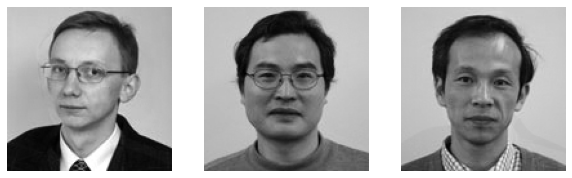

In [ ]:
sources = get_sources(mixes)
show_images([sources], figsize=(10, 6))

Ура. Что-то получилось. Теперь соберём всё вместе.

In [ ]:
def show_bss(images):
    mixes = random_mixes(images, count=len(images))
    sources = get_sources(mixes)
    show_images([images, mixes, sources], figsize=(10, 9))

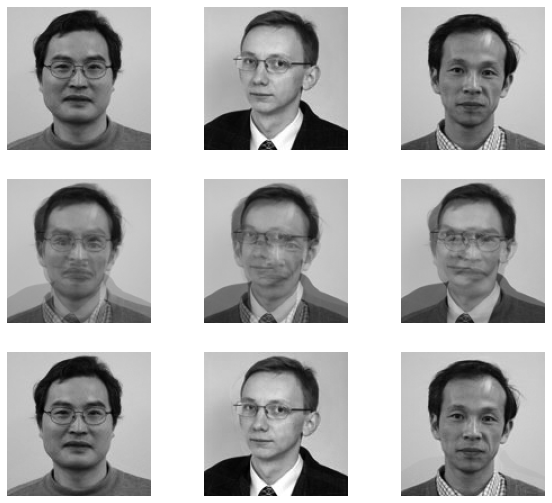

In [ ]:
show_bss(images)

Испытаем наш алгоритм на других изображениях.

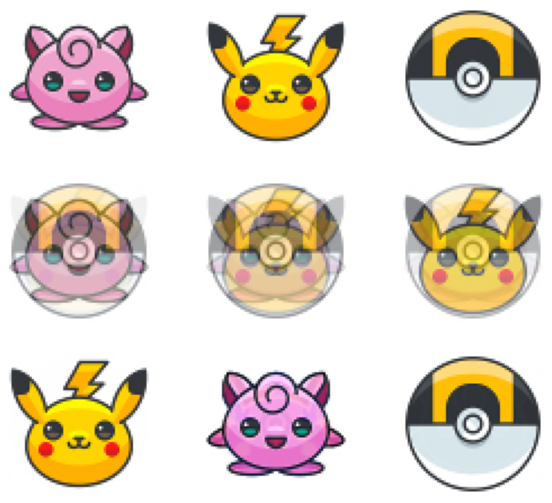

In [10]:
cool_images = get_images(['kek1.jpg', 'kek2.jpg', 'kek3.jpg'])
show_bss(less_cool_images)

В итоге, у нас получилось разделить смеси на составляющие. Однако алгоритм требует довольно много ресурсов (времени и памяти) из-за необходимости решения задачи линейного программирования. Поэтому для работы с реальными данными необходимо произвести некоторые оптимизации.